In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

There are 496 observations in the training data
There are 77 observations in the test data


,Unnamed: 0,Date,Open,High,Low,Close,Adj.Close,Volume,일일종가차이
0,1,2020-01-02,30800.0,30900,30400.0,30500,30473.498047,1205235,-200
1,2,2020-01-03,30700.0,31000,30200.0,30500,30473.498047,1574240,0
2,3,2020-01-06,30100.0,31000,30000.0,30900,30873.152344,1968575,400
3,4,2020-01-07,31000.0,32000,30900.0,32000,31972.195313,4200930,1100
4,5,2020-01-08,31700.0,32400,31300.0,31900,31872.283203,4258095,-100
...,...,...,...,...,...,...,...,...,...
491,492,2021-12-24,113000.0,115000,112500.0,114500,114446.531250,1484508,1500
492,493,2021-12-27,114000.0,114500,113000.0,113000,112947.234375,1116701,-1500
493,494,2021-12-28,113000.0,114000,113000.0,113500,113447.000000,2370856,500
494,495,2021-12-29,115500.0,117500,114000.0,114000,114000.000000,1791503,500


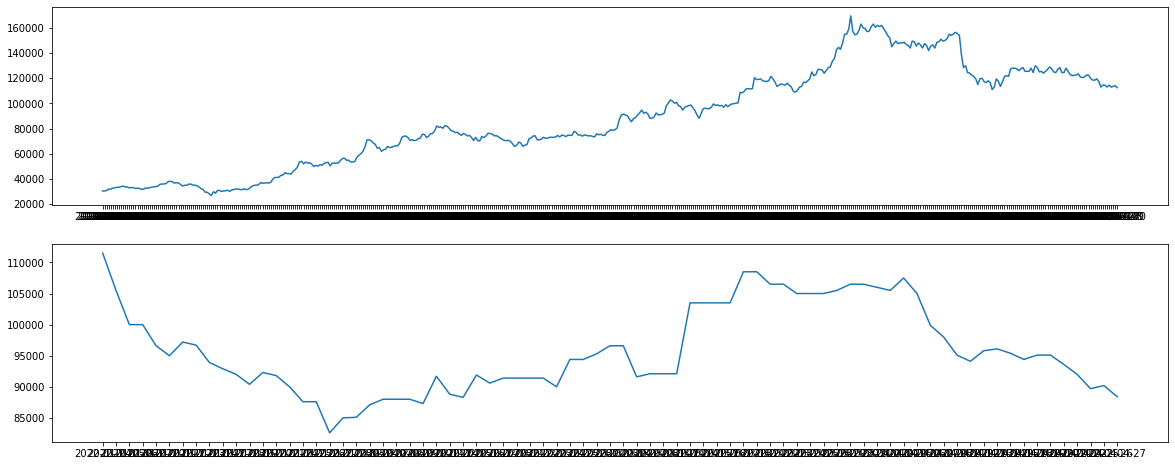

In [3]:
# 주가 데이터 불러오기
price_train = pd.read_csv('./data/주가_train_data.csv')
price_test = pd.read_csv('./data/주가_test_data.csv')

print("There are "+str(price_train.shape[0])+" observations in the training data")
print("There are "+str(price_test.shape[0])+" observations in the test data")

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.plot(price_train['Date'],price_train['Adj.Close'])

plt.subplot(212)
plt.plot(price_test['Date'],price_test['Adj.Close'])

price_train
# price_test

In [4]:
#price_train = price_train.set_index('Date', drop=True)
#price_train = price_train.drop('Unnamed: 0', axis=1)
price_train = price_train[['Adj.Close']]
price_train

,Adj.Close
0,30473.498047
1,30473.498047
2,30873.152344
3,31972.195313
4,31872.283203
...,...
491,114446.531250
492,112947.234375
493,113447.000000
494,114000.000000


In [5]:
#price_test = price_test.set_index('Date', drop=True)
#price_test = price_test.drop('Unnamed: 0', axis=1)
price_test = price_test[['Adj.Close']]
price_test

,Adj.Close
0,111500.0
1,105500.0
2,100000.0
3,100000.0
4,96600.0
...,...
72,93600.0
73,92000.0
74,89700.0
75,90200.0


In [6]:
def ts_train_test_normalize(time_steps, for_periods):
    """
    input: 
        data: dataframe with dates and price data
    output: 
        X_train, y_train: data from 2013/1/1-2018/12/31 
        X_test : data from 2019- 
        sc :     insantiated MinMaxScaler object fit to the training data 
    """
    # create training and test set 
    ts_train = price_train.values
    ts_test = price_test.values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((price_train, price_test), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc 

In [7]:
X_train, y_train, X_test, sc = ts_train_test_normalize(5,2)
X_train.shape[0], X_train.shape[1]
X_train

array([[[0.02591614],
        [0.02591614],
        [0.02871789],
        [0.03642268],
        [0.03572225]],

       [[0.02591614],
        [0.02871789],
        [0.03642268],
        [0.03572225],
        [0.04202617]],

       [[0.02871789],
        [0.03642268],
        [0.03572225],
        [0.04202617],
        [0.04342706]],

       ...,

       [[0.60409434],
        [0.61460509],
        [0.61460509],
        [0.60409434],
        [0.61460509]],

       [[0.61460509],
        [0.61460509],
        [0.60409434],
        [0.61460509],
        [0.60409434]],

       [[0.61460509],
        [0.60409434],
        [0.61460509],
        [0.60409434],
        [0.60759792]]])

In [47]:
# Convert the 3D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# Convert the 3D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 490 samples in the training data
There are 75 samples in the test data


In [54]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD
    from keras.optimizers import gradient_descent_v2
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
#     my_GRU_model.add(GRU(units = 50, 
#                          activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(#lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = #50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

In [65]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['Adj.Close', 'prediction'])
    actual_pred['Adj.Close'] = price_test['Adj.Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj.Close']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

c:\users\imj\pycharmprojects\pythonproject\venv\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(15976175.0, <AxesSubplot:xlabel='Date'>)

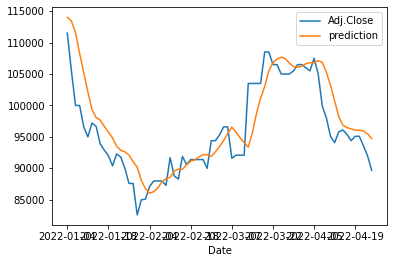

In [66]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [70]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru = price_test['Adj.Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [71]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,3004.17823
RMSE,3997.02067
RMSLE,0.04047
R2,0.66478
